In [28]:
import os
import cv2

from helpers.dataset_process import dataset_to_df, search_df
# from engine import train_fn, eval_fn

import numpy as np
# import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
# from torch import Tensor
import torch.nn as nn
# import torch.nn.functional as F

# The cross-entropy loss penalizes the model more when it is more confident in the incorrect class
from torch.nn import CrossEntropyLoss

# Adam is an optimization algorithm that can be used instead of the classical SGD procedure
# to update network weights iterative based in training data.
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision import transforms
from torchvision.transforms import v2
# from torchvision.transforms.autoaugment import AutoAugment,AutoAugmentPolicy
from torchvision.io import read_image

# import albumentations as alb

from torchinfo import summary

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# from typing import Optional, Tuple
# import timm
# import wandb
# import time
# from utils import progress_bar
# import csv

In [29]:
print(f"torch version: {torch.__version__}")
print(f"GPU Card: {torch.cuda.get_device_name(0)}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Torch is using device:', device)
torch.cuda.get_device_name(device)

NUM_WORKERS = os.cpu_count()
print("CPU Count:", NUM_WORKERS)

torch version: 2.2.1+cu121
GPU Card: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Torch is using device: cuda:0
CPU Count: 20


In [30]:
start_from_model = False
model_state_path = "../../../weights/vit_cifak/checkpoint/"
model_file_name = "vit_patch8_cifak_epoch_97"

In [31]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.model(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, emb_dropout = 0., dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [32]:
path = '../../../data/CIFAK'
relative_paths = ["/train/REAL", "/train/FAKE", "/test/REAL", "/test/FAKE"]
paths_classes = ["REAL", "FAKE", "REAL", "FAKE"]

In [33]:
df_all, df_train, df_val, df_test, classes_stats = dataset_to_df(path, relative_paths, paths_classes, 0.8, 0.19, 0.01)

classes_stats

,REAL,FAKE,Total
Training,48000,48000,96000
Validation,11400,11400,22800
Testing,600,600,1200
Row_Total,60000,60000,120000


In [34]:
img_size = 32
patch_size = 8
trans_img_resize = 32
image_patch_flat_size = 3*patch_size**2
embed_size = image_patch_flat_size
mlp_dim = 512
train_batch_size = 64
valid_batch_size = 32
num_classes = 2
encoder_depth = 6
attention_heads = 12

print(f'Flattened dimension size(of a patch): {image_patch_flat_size}')
print(f'Embedding Size: {embed_size}')
print(f'Output MLP size: {mlp_dim}')

Flattened dimension size(of a patch): 192
Embedding Size: 192
Output MLP size: 512


In [35]:
norm_mean = [0.4913997551666284, 0.48215855929893703, 0.4465309133731618]
norm_std = [0.24703225141799082, 0.24348516474564, 0.26158783926049628]

In [36]:
# Custom Dataset Class
class Images_Dataset(Dataset):
    def __init__(self, annotations_df, transform=None):
        
        self.annotation = annotations_df
        self.transform = transform

    def __getitem__(self, index):
        
        img = read_image(self.annotation.iloc[index, 0])
        labels = torch.tensor(self.annotation.iloc[index, 3],dtype=torch.int64)

        if self.transform:
            img_t = self.transform(img)

        return img_t, labels

    def __len__(self):
        # To return the length of the dataset
        return self.annotation.shape[0]

In [37]:
transform_train = transforms.Compose([
    # v2.ToPILImage(),
    # v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),
    # transforms.RandAugment(2, 14),
    v2.RandomCrop(32, padding=4),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomAffine(degrees=(0, 180), translate=(0.1, 0.3), scale=(0.5, 0.75)),
    # v2.RandomPerspective(distortion_scale=0.6, p=1.0),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    # v2.ToTensor(),
    v2.Normalize(norm_mean, norm_std),
])

transform_valid = transforms.Compose([
    v2.Resize(trans_img_resize),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(norm_mean, norm_std),
])

In [38]:
# Define the dataset object and configure the Data Loader

train_set  = Images_Dataset(df_train, transform_train)

train_loader = DataLoader(dataset=train_set,
                          batch_size=train_batch_size,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)


valid_set  = Images_Dataset(df_val, transform_valid)

valid_loader= DataLoader(dataset=valid_set ,
                          batch_size=valid_batch_size,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)

In [39]:
print("First and Last Elements in the Whole dataset")
df_all.iloc[[0,-1]]

First and Last Elements in the Whole dataset


,Image_path,Image_size,Class,Class_Codes,Class_Onehot
0,../../../data/CIFAK//train/REAL/0000(10).jpg,"(3, 32, 32)",REAL,1,"[1, 0]"
119999,../../../data/CIFAK//test/FAKE/999.jpg,"(3, 32, 32)",FAKE,0,"[0, 1]"


In [40]:
print(len(train_loader)*train_loader.batch_size)


96000


In [41]:
sample_img_batch,label = next(iter(train_loader))

print(f"Batch of Images Shape: {sample_img_batch.size()}")
print(f"Batch of Images Shape: {label.size()}")
print(label)

Batch of Images Shape: torch.Size([64, 3, 32, 32])
Batch of Images Shape: torch.Size([64])
tensor([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1])


In [42]:
class SliceImage:
    def __init__(self, slice_width):
        self.slice_width = slice_width

    def slice(self, img):
        # c: color channels

        # h: desired slice height (pixels)
        # w: desired slice width (pixels)

        # row: No. of vertical slices
        # col: No. of horizontal slices

        # b: Batch of Images

        sliced_Img = rearrange(
            img, 'c (row h) (col w) -> row col c h w', h=self.slice_width, w=self.slice_width)

        return sliced_Img

    def __call__(self, img):
        sliced_img = self.slice(img)
        sliced_flattened_img = rearrange(
            sliced_img, 'row col c h w -> (row col) (c h w)')

        return sliced_flattened_img

    plt.show()

In [43]:
def img_data(train_loader, index):

    img, label = train_loader.dataset[index]

    channels, img_H, img_W = img.size()
    
    batch = train_loader.batch_size

    return img, label, channels, img_H, batch

In [44]:
def img_plot(img, slice_width):
    slice = SliceImage(slice_width)
    sliced_img = slice.slice(img)
    print("Sliced Image Shape: ", sliced_img.shape)

    fig = plt.figure(layout="constrained", figsize=(8, 4))
    subfigs = fig.subfigures(3, 1, height_ratios=[1., 1.5, 1.], hspace=0.05, squeeze='True')

    axs0 = subfigs[0].subplots(1, 1)
    img_a = rearrange(img, "c h w -> h w c").numpy()
    
    axs0.imshow(img_a)
    axs0.axis('off')
    # subfigs[0].suptitle('Input Image', fontsize=10)

    grid1 = ImageGrid(subfigs[1], 111, nrows_ncols=(sliced_img.size(0), sliced_img.size(1)), axes_pad=0.03)

    for i, ax in enumerate(grid1):
        i_b4 = str(np.base_repr(i, sliced_img.size(0))).zfill(2)
        row = int(i_b4[0])
        column = int(i_b4[1])
        patch = rearrange(sliced_img[row][column], "c h w -> h w c").numpy()
        
        ax.imshow(patch)
        ax.axis('off')
    # subfigs[1].suptitle('Slices', fontsize=10)

    grid2 = ImageGrid(subfigs[2], 111, nrows_ncols=(1, sliced_img.size(0)*sliced_img.size(1)), axes_pad=0.03)

    for i, ax in enumerate(grid2):
        i_b4 = str(np.base_repr(i, sliced_img.size(0))).zfill(2)
        row = int(i_b4[0])
        column = int(i_b4[1])
        patch = sliced_img[row][column].permute(1, 2, 0).numpy()
        
        ax.imshow(patch)
        ax.axis('off')
    # subfigs[2].suptitle('Position', fontsize=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input Image Shape: torch.Size([3, 32, 32])
Sliced Image Shape:  torch.Size([4, 4, 3, 8, 8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i


slice_embed 192


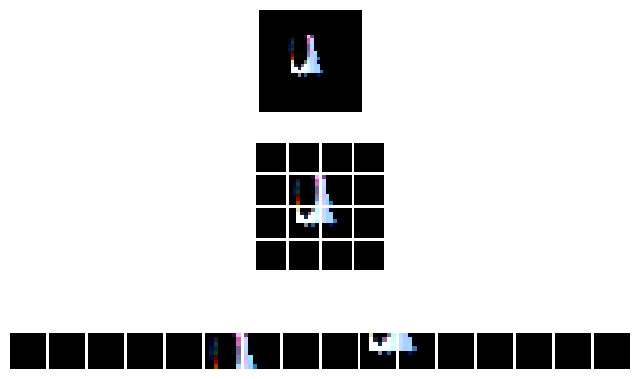

In [45]:
sample_img, _ = train_set[100]
sample_img_tr, sample_img_label, ch, img_size, batch_size = img_data(train_loader, 2)
print(f"Input Image Shape: {sample_img_tr.size()}")
img_plot(sample_img, patch_size)

print("")

slice_embed = embed_size
print("slice_embed", slice_embed)

In [46]:
model = ViT(
    image_size=img_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=slice_embed,
    depth=encoder_depth,
    heads=attention_heads,
    mlp_dim=mlp_dim,
    emb_dropout=0.1,
    dropout=0.1
)


In [47]:
vit_output = model(sample_img_batch)

print("Input Shape: ", sample_img_batch.size())
print("Output Shape: ", vit_output.size())

summary(model=model,
        input_size=sample_img_batch.size(),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Input Shape:  torch.Size([64, 3, 32, 32])
Output Shape:  torch.Size([64, 2])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [64, 3, 32, 32]      [64, 2]              3,456                True
├─Sequential (to_patch_embedding)                  [64, 3, 32, 32]      [64, 16, 192]        --                   True
│    └─Rearrange (0)                               [64, 3, 32, 32]      [64, 16, 192]        --                   --
│    └─Linear (1)                                  [64, 16, 192]        [64, 16, 192]        37,056               True
├─Dropout (dropout)                                [64, 17, 192]        [64, 17, 192]        --                   --
├─Transformer (transformer)                        [64, 17, 192]        [64, 17, 192]        --                   True
│    └─ModuleList (layers)                         --                   --                   --                   True
│    │    └─ModuleList (0)                     

In [48]:
n_epochs = 500         # Number of epochs
base_lr = 10e-3         # Base LR
# weight_decay = 0.03     # Weight decay for ViT-Base (on ImageNet-21k)

In [49]:
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=base_lr)
# optimizer = optim.SGD(model.parameters(), lr=base_lr)  
    
# use cosine scheduling
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

In [50]:
if start_from_model:
    checkpoint = torch.load(model_state_path+model_file_name)
    model.load_state_dict(checkpoint['model'])
    
    start_epoch = checkpoint['epoch']
    best_acc = checkpoint['best_acc']
    list_tr_loss = checkpoint['list_tr_loss']
    list_tr_acc = checkpoint['list_tr_acc']
    list_val_loss = checkpoint['list_val_loss']
    list_val_acc = checkpoint['list_val_acc']
else:
    start_epoch = 0  
    best_acc = 0

    list_tr_loss = []
    list_tr_acc = []
    list_val_loss = []
    list_val_acc = []

In [51]:
        # print("targets size",targets.size())
        # print("target",targets[0])
        # print("target type",targets[0].type())
        # print("outputs size",outputs.size())
        # print("outputs",outputs[0])

In [25]:
model.to(device)
for epoch in range(start_epoch, n_epochs):

    print(f'\n epoch: {epoch+1}/{n_epochs}')

    ##########################################################
    model.train(True)
    tr_loss = 0
    correct = 0
    total = 0

    loop1 = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (inputs, targets) in loop1:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)


        # Zero gradients for every batch
        optimizer.zero_grad()
        # Backward path (Gradient)
        loss.backward()
        # Optimizer(Adam) Step
        optimizer.step()

        tr_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        avg_tr_loss = tr_loss/(batch_idx+1)
        avg_tr_accuracy = 100.*correct/total

        loop1.set_description(f"Train--Epoch [{epoch+1}/{n_epochs}]")
        loop1.set_postfix(loss=avg_tr_loss, acc=avg_tr_accuracy)

    ##########################################################
    list_tr_loss.append(avg_tr_loss)
    list_tr_acc.append(avg_tr_accuracy)

    ##########################################################
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():

        loop2 = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for batch_idx, (inputs, targets) in loop2:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            avg_val_loss = val_loss/(batch_idx+1)
            avg_val_accuracy = 100.*correct/total

            loop2.set_description(f"Valid--Epoch [{epoch+1}/{n_epochs}]")
            loop2.set_postfix(loss=avg_val_loss, acc=avg_val_accuracy)

    list_val_loss.append(avg_val_loss)
    list_val_acc.append(avg_val_accuracy)

    # Save checkpoint.
    if avg_val_accuracy > best_acc:
        best_acc = avg_val_accuracy

        print('Saving..')
        state = {"model": model.state_dict(),
                 "optimizer": optimizer.state_dict(),
                 "epoch": epoch,
                 "list_tr_loss": list_tr_loss,
                 "list_tr_acc": list_tr_acc,
                 "list_val_loss": list_val_loss,
                 "list_val_acc": list_val_acc
                 }
        torch.save(state, model_state_path +
                   f'vit_patch{patch_size}_cifak_epoch_{epoch}')

    ##########################################################

    scheduler.step()  # step cosine scheduling


 epoch: 1/500


Valid--Epoch [1/500]: 100%|██████████| 712/712 [00:04<00:00, 152.10it/s, acc=49.6, loss=0.816]


Saving..

 epoch: 2/500


Valid--Epoch [2/500]: 100%|██████████| 712/712 [00:04<00:00, 150.55it/s, acc=52.4, loss=0.692]


Saving..

 epoch: 3/500


Valid--Epoch [3/500]: 100%|██████████| 712/712 [00:04<00:00, 153.35it/s, acc=51.6, loss=0.75] 



 epoch: 4/500


Valid--Epoch [4/500]: 100%|██████████| 712/712 [00:04<00:00, 151.49it/s, acc=52.7, loss=0.933]


Saving..

 epoch: 5/500


Valid--Epoch [5/500]: 100%|██████████| 712/712 [00:04<00:00, 146.45it/s, acc=54.9, loss=0.743]


Saving..

 epoch: 6/500


Valid--Epoch [6/500]: 100%|██████████| 712/712 [00:04<00:00, 144.12it/s, acc=53, loss=0.726]  


 epoch: 7/500



Valid--Epoch [7/500]: 100%|██████████| 712/712 [00:04<00:00, 145.44it/s, acc=52.8, loss=0.765]


 epoch: 8/500



Valid--Epoch [8/500]: 100%|██████████| 712/712 [00:05<00:00, 141.65it/s, acc=53, loss=0.835]  


 epoch: 9/500



Valid--Epoch [9/500]: 100%|██████████| 712/712 [00:04<00:00, 142.41it/s, acc=54.8, loss=0.742]



 epoch: 10/500


Valid--Epoch [10/500]: 100%|██████████| 712/712 [00:04<00:00, 143.00it/s, acc=56.6, loss=0.696]


Saving..

 epoch: 11/500


Valid--Epoch [11/500]: 100%|██████████| 712/712 [00:05<00:00, 134.73it/s, acc=55.9, loss=0.692]



 epoch: 12/500


Valid--Epoch [12/500]: 100%|██████████| 712/712 [00:05<00:00, 135.05it/s, acc=54.9, loss=0.701]



 epoch: 13/500


Valid--Epoch [13/500]: 100%|██████████| 712/712 [00:05<00:00, 131.66it/s, acc=55.8, loss=0.715]


 epoch: 14/500



Valid--Epoch [14/500]: 100%|██████████| 712/712 [00:05<00:00, 129.11it/s, acc=56.5, loss=0.719]



 epoch: 15/500


Valid--Epoch [15/500]: 100%|██████████| 712/712 [00:05<00:00, 130.00it/s, acc=57.1, loss=0.723]


Saving..

 epoch: 16/500


Valid--Epoch [16/500]: 100%|██████████| 712/712 [00:05<00:00, 130.79it/s, acc=57, loss=0.702]  


 epoch: 17/500



Valid--Epoch [17/500]: 100%|██████████| 712/712 [00:05<00:00, 125.39it/s, acc=55.7, loss=0.727]


 epoch: 18/500



Valid--Epoch [18/500]: 100%|██████████| 712/712 [00:05<00:00, 126.99it/s, acc=57.3, loss=0.736]


Saving..

 epoch: 19/500


Valid--Epoch [19/500]: 100%|██████████| 712/712 [00:05<00:00, 129.56it/s, acc=57.4, loss=0.693]


Saving..

 epoch: 20/500


Valid--Epoch [20/500]: 100%|██████████| 712/712 [00:05<00:00, 128.38it/s, acc=56.4, loss=0.716]



 epoch: 21/500


Valid--Epoch [21/500]: 100%|██████████| 712/712 [00:05<00:00, 125.43it/s, acc=56.4, loss=0.716]



 epoch: 22/500


Valid--Epoch [22/500]: 100%|██████████| 712/712 [00:05<00:00, 125.27it/s, acc=56.2, loss=0.726]


 epoch: 23/500



Valid--Epoch [23/500]: 100%|██████████| 712/712 [00:05<00:00, 127.33it/s, acc=55.2, loss=0.702]


 epoch: 24/500



Valid--Epoch [24/500]: 100%|██████████| 712/712 [00:05<00:00, 122.98it/s, acc=55.7, loss=0.721]



 epoch: 25/500


Valid--Epoch [25/500]: 100%|██████████| 712/712 [00:05<00:00, 125.30it/s, acc=56.4, loss=0.745]



 epoch: 26/500


Valid--Epoch [26/500]: 100%|██████████| 712/712 [00:05<00:00, 127.77it/s, acc=54.9, loss=0.742]


 epoch: 27/500



Valid--Epoch [27/500]: 100%|██████████| 712/712 [00:05<00:00, 126.29it/s, acc=56.5, loss=0.773]



 epoch: 28/500


Valid--Epoch [28/500]: 100%|██████████| 712/712 [00:05<00:00, 126.74it/s, acc=55.6, loss=0.758]



 epoch: 29/500


Valid--Epoch [29/500]: 100%|██████████| 712/712 [00:05<00:00, 128.04it/s, acc=54.5, loss=0.766]



 epoch: 30/500


Valid--Epoch [30/500]: 100%|██████████| 712/712 [00:05<00:00, 126.97it/s, acc=55.9, loss=0.734]


 epoch: 31/500



Valid--Epoch [31/500]: 100%|██████████| 712/712 [00:05<00:00, 125.64it/s, acc=56.7, loss=0.705]


 epoch: 32/500



Valid--Epoch [32/500]: 100%|██████████| 712/712 [00:05<00:00, 126.56it/s, acc=57.6, loss=0.756]


Saving..

 epoch: 33/500


Valid--Epoch [33/500]: 100%|██████████| 712/712 [00:05<00:00, 128.13it/s, acc=56.6, loss=0.713]


 epoch: 34/500



Valid--Epoch [34/500]: 100%|██████████| 712/712 [00:05<00:00, 128.95it/s, acc=56.3, loss=0.752]


 epoch: 35/500



Valid--Epoch [35/500]: 100%|██████████| 712/712 [00:05<00:00, 126.47it/s, acc=56.7, loss=0.727]



 epoch: 36/500


Valid--Epoch [36/500]: 100%|██████████| 712/712 [00:05<00:00, 125.24it/s, acc=56.5, loss=0.726]


 epoch: 37/500



Valid--Epoch [37/500]: 100%|██████████| 712/712 [00:05<00:00, 126.43it/s, acc=57.1, loss=0.698]



 epoch: 38/500


Valid--Epoch [38/500]: 100%|██████████| 712/712 [00:05<00:00, 126.37it/s, acc=57.4, loss=0.698]



 epoch: 39/500


Valid--Epoch [39/500]: 100%|██████████| 712/712 [00:05<00:00, 127.64it/s, acc=56.5, loss=0.727]



 epoch: 40/500


Valid--Epoch [40/500]: 100%|██████████| 712/712 [00:05<00:00, 128.12it/s, acc=57.4, loss=0.722]



 epoch: 41/500


Valid--Epoch [41/500]: 100%|██████████| 712/712 [00:05<00:00, 126.12it/s, acc=56.8, loss=0.699]


 epoch: 42/500



Valid--Epoch [42/500]: 100%|██████████| 712/712 [00:05<00:00, 126.28it/s, acc=57.9, loss=0.724]


Saving..

 epoch: 43/500


Valid--Epoch [43/500]: 100%|██████████| 712/712 [00:05<00:00, 126.78it/s, acc=57.2, loss=0.752]


 epoch: 44/500



Valid--Epoch [44/500]: 100%|██████████| 712/712 [00:05<00:00, 127.02it/s, acc=58.3, loss=0.73] 


Saving..

 epoch: 45/500


Valid--Epoch [45/500]: 100%|██████████| 712/712 [00:05<00:00, 123.66it/s, acc=55, loss=0.699]  


 epoch: 46/500



Valid--Epoch [46/500]: 100%|██████████| 712/712 [00:05<00:00, 128.56it/s, acc=57.4, loss=0.676]


 epoch: 47/500



Valid--Epoch [47/500]: 100%|██████████| 712/712 [00:05<00:00, 126.86it/s, acc=57.8, loss=0.714]


 epoch: 48/500



Valid--Epoch [48/500]: 100%|██████████| 712/712 [00:05<00:00, 127.43it/s, acc=57.1, loss=0.72] 


 epoch: 49/500



Valid--Epoch [49/500]: 100%|██████████| 712/712 [00:05<00:00, 124.09it/s, acc=57.4, loss=0.729]


 epoch: 50/500



Valid--Epoch [50/500]: 100%|██████████| 712/712 [00:05<00:00, 127.26it/s, acc=56.9, loss=0.758]


 epoch: 51/500



Valid--Epoch [51/500]: 100%|██████████| 712/712 [00:05<00:00, 126.40it/s, acc=57.3, loss=0.748]


 epoch: 52/500



Valid--Epoch [52/500]: 100%|██████████| 712/712 [00:05<00:00, 127.24it/s, acc=57.5, loss=0.777]


 epoch: 53/500



Valid--Epoch [53/500]: 100%|██████████| 712/712 [00:05<00:00, 125.22it/s, acc=52.1, loss=0.77] 



 epoch: 54/500


Valid--Epoch [54/500]: 100%|██████████| 712/712 [00:05<00:00, 126.13it/s, acc=57, loss=0.775]  


 epoch: 55/500



Valid--Epoch [55/500]: 100%|██████████| 712/712 [00:05<00:00, 126.73it/s, acc=57.1, loss=0.747]



 epoch: 56/500


Valid--Epoch [56/500]: 100%|██████████| 712/712 [00:05<00:00, 126.72it/s, acc=56.8, loss=0.723]



 epoch: 57/500


Valid--Epoch [57/500]: 100%|██████████| 712/712 [00:05<00:00, 128.21it/s, acc=58.1, loss=0.761]


 epoch: 58/500



Valid--Epoch [58/500]: 100%|██████████| 712/712 [00:05<00:00, 128.04it/s, acc=58.3, loss=0.745]


Saving..

 epoch: 59/500


Valid--Epoch [59/500]: 100%|██████████| 712/712 [00:05<00:00, 127.39it/s, acc=57.9, loss=0.732]


 epoch: 60/500



Valid--Epoch [60/500]: 100%|██████████| 712/712 [00:05<00:00, 127.18it/s, acc=57.9, loss=0.718]


 epoch: 61/500



Valid--Epoch [61/500]: 100%|██████████| 712/712 [00:05<00:00, 127.61it/s, acc=57.7, loss=0.744]


 epoch: 62/500



Valid--Epoch [62/500]: 100%|██████████| 712/712 [00:05<00:00, 127.27it/s, acc=57.9, loss=0.744]



 epoch: 63/500


Valid--Epoch [63/500]: 100%|██████████| 712/712 [00:05<00:00, 127.59it/s, acc=57.1, loss=0.723]



 epoch: 64/500


Valid--Epoch [64/500]: 100%|██████████| 712/712 [00:05<00:00, 126.82it/s, acc=57.2, loss=0.748]


 epoch: 65/500



Valid--Epoch [65/500]: 100%|██████████| 712/712 [00:05<00:00, 127.25it/s, acc=57.7, loss=0.741]


 epoch: 66/500



Valid--Epoch [66/500]: 100%|██████████| 712/712 [00:05<00:00, 125.07it/s, acc=58.2, loss=0.721]


 epoch: 67/500



Valid--Epoch [67/500]: 100%|██████████| 712/712 [00:05<00:00, 126.14it/s, acc=57.5, loss=0.754]


 epoch: 68/500



Valid--Epoch [68/500]: 100%|██████████| 712/712 [00:05<00:00, 126.82it/s, acc=57, loss=0.76]   


 epoch: 69/500



Valid--Epoch [69/500]: 100%|██████████| 712/712 [00:05<00:00, 125.70it/s, acc=56.8, loss=0.718]


 epoch: 70/500



Valid--Epoch [70/500]: 100%|██████████| 712/712 [00:05<00:00, 126.27it/s, acc=58.5, loss=0.721]


Saving..

 epoch: 71/500


Valid--Epoch [71/500]: 100%|██████████| 712/712 [00:05<00:00, 125.72it/s, acc=57.5, loss=0.751]


 epoch: 72/500



Valid--Epoch [72/500]: 100%|██████████| 712/712 [00:05<00:00, 125.63it/s, acc=57.1, loss=0.795]


 epoch: 73/500



Valid--Epoch [73/500]: 100%|██████████| 712/712 [00:05<00:00, 125.89it/s, acc=57.8, loss=0.738]


 epoch: 74/500



Valid--Epoch [74/500]: 100%|██████████| 712/712 [00:05<00:00, 126.01it/s, acc=56.8, loss=0.792]


 epoch: 75/500



Valid--Epoch [75/500]: 100%|██████████| 712/712 [00:05<00:00, 123.43it/s, acc=57.9, loss=0.728]


 epoch: 76/500



Valid--Epoch [76/500]: 100%|██████████| 712/712 [00:05<00:00, 125.50it/s, acc=58.7, loss=0.69] 


Saving..

 epoch: 77/500


Valid--Epoch [77/500]: 100%|██████████| 712/712 [00:05<00:00, 125.59it/s, acc=58, loss=0.733]  


 epoch: 78/500



Valid--Epoch [78/500]: 100%|██████████| 712/712 [00:05<00:00, 127.53it/s, acc=58, loss=0.737]  



 epoch: 79/500


Valid--Epoch [79/500]: 100%|██████████| 712/712 [00:05<00:00, 125.11it/s, acc=58.7, loss=0.764]


Saving..

 epoch: 80/500


Valid--Epoch [80/500]: 100%|██████████| 712/712 [00:05<00:00, 125.56it/s, acc=58.6, loss=0.759]



 epoch: 81/500


Valid--Epoch [81/500]: 100%|██████████| 712/712 [00:05<00:00, 124.38it/s, acc=57.8, loss=0.818]



 epoch: 82/500


Valid--Epoch [82/500]: 100%|██████████| 712/712 [00:05<00:00, 124.34it/s, acc=58.9, loss=0.71] 


Saving..

 epoch: 83/500


Valid--Epoch [83/500]: 100%|██████████| 712/712 [00:05<00:00, 124.04it/s, acc=54.2, loss=0.749]


 epoch: 84/500



Valid--Epoch [84/500]: 100%|██████████| 712/712 [00:05<00:00, 124.54it/s, acc=55.3, loss=0.756]



 epoch: 85/500


Valid--Epoch [85/500]: 100%|██████████| 712/712 [00:05<00:00, 124.61it/s, acc=57.2, loss=0.738]


 epoch: 86/500



Valid--Epoch [86/500]: 100%|██████████| 712/712 [00:06<00:00, 117.80it/s, acc=58, loss=0.689]  


 epoch: 87/500



Valid--Epoch [87/500]: 100%|██████████| 712/712 [00:05<00:00, 118.96it/s, acc=58.1, loss=0.705]


 epoch: 88/500



Valid--Epoch [88/500]: 100%|██████████| 712/712 [00:06<00:00, 114.00it/s, acc=54.4, loss=0.752]


 epoch: 89/500



Valid--Epoch [89/500]: 100%|██████████| 712/712 [00:06<00:00, 118.38it/s, acc=57.5, loss=0.728]


 epoch: 90/500



Valid--Epoch [90/500]: 100%|██████████| 712/712 [00:06<00:00, 114.20it/s, acc=58.4, loss=0.726]


 epoch: 91/500



Valid--Epoch [91/500]: 100%|██████████| 712/712 [00:05<00:00, 119.68it/s, acc=57.7, loss=0.711]


 epoch: 92/500



Valid--Epoch [92/500]: 100%|██████████| 712/712 [00:05<00:00, 123.48it/s, acc=57.6, loss=0.705]



 epoch: 93/500


Valid--Epoch [93/500]: 100%|██████████| 712/712 [00:05<00:00, 126.02it/s, acc=58.3, loss=0.706]


 epoch: 94/500



Valid--Epoch [94/500]: 100%|██████████| 712/712 [00:05<00:00, 123.54it/s, acc=58, loss=0.748]  


 epoch: 95/500



Valid--Epoch [95/500]: 100%|██████████| 712/712 [00:05<00:00, 124.14it/s, acc=56.3, loss=0.75] 



 epoch: 96/500


Valid--Epoch [96/500]: 100%|██████████| 712/712 [00:05<00:00, 125.56it/s, acc=58.7, loss=0.713]


 epoch: 97/500



Valid--Epoch [97/500]: 100%|██████████| 712/712 [00:05<00:00, 126.12it/s, acc=58.9, loss=0.737]


Saving..

 epoch: 98/500


Valid--Epoch [98/500]: 100%|██████████| 712/712 [00:05<00:00, 124.69it/s, acc=59.4, loss=0.726]


Saving..

 epoch: 99/500


Valid--Epoch [99/500]: 100%|██████████| 712/712 [00:05<00:00, 126.56it/s, acc=59.2, loss=0.756]


 epoch: 100/500



Valid--Epoch [100/500]: 100%|██████████| 712/712 [00:06<00:00, 113.87it/s, acc=58.7, loss=0.785]


 epoch: 101/500



Valid--Epoch [101/500]: 100%|██████████| 712/712 [00:05<00:00, 126.04it/s, acc=59.3, loss=0.719]


 epoch: 102/500



Valid--Epoch [102/500]: 100%|██████████| 712/712 [00:05<00:00, 124.85it/s, acc=58.8, loss=0.719]


 epoch: 103/500



Valid--Epoch [103/500]: 100%|██████████| 712/712 [00:05<00:00, 123.84it/s, acc=58.7, loss=0.72] 



 epoch: 104/500


Valid--Epoch [104/500]: 100%|██████████| 712/712 [00:05<00:00, 123.46it/s, acc=58.4, loss=0.717]



 epoch: 105/500


Valid--Epoch [105/500]: 100%|██████████| 712/712 [00:05<00:00, 124.46it/s, acc=58.4, loss=0.789]


 epoch: 106/500



Valid--Epoch [106/500]: 100%|██████████| 712/712 [00:05<00:00, 124.69it/s, acc=58.7, loss=0.731]


 epoch: 107/500



Valid--Epoch [107/500]: 100%|██████████| 712/712 [00:05<00:00, 124.79it/s, acc=58.9, loss=0.766]


 epoch: 108/500



Valid--Epoch [108/500]: 100%|██████████| 712/712 [00:05<00:00, 125.36it/s, acc=58.3, loss=0.784]



 epoch: 109/500


Valid--Epoch [109/500]: 100%|██████████| 712/712 [00:05<00:00, 124.70it/s, acc=58.5, loss=0.702]



 epoch: 110/500


Valid--Epoch [110/500]: 100%|██████████| 712/712 [00:05<00:00, 124.62it/s, acc=59.2, loss=0.735]


 epoch: 111/500



Valid--Epoch [111/500]: 100%|██████████| 712/712 [00:05<00:00, 122.82it/s, acc=59, loss=0.706]  


 epoch: 112/500



Valid--Epoch [112/500]: 100%|██████████| 712/712 [00:05<00:00, 124.32it/s, acc=59.1, loss=0.694]



 epoch: 113/500


Valid--Epoch [113/500]: 100%|██████████| 712/712 [00:05<00:00, 123.07it/s, acc=59, loss=0.784]  


 epoch: 114/500



Valid--Epoch [114/500]: 100%|██████████| 712/712 [00:05<00:00, 125.37it/s, acc=57.8, loss=0.786]


 epoch: 115/500



Valid--Epoch [115/500]: 100%|██████████| 712/712 [00:05<00:00, 123.49it/s, acc=58.9, loss=0.747]


 epoch: 116/500



Valid--Epoch [116/500]: 100%|██████████| 712/712 [00:05<00:00, 124.69it/s, acc=58.2, loss=0.772]


 epoch: 117/500



Valid--Epoch [117/500]: 100%|██████████| 712/712 [00:05<00:00, 123.06it/s, acc=58.7, loss=0.731]


 epoch: 118/500



Valid--Epoch [118/500]: 100%|██████████| 712/712 [00:05<00:00, 121.49it/s, acc=58.8, loss=0.786]



 epoch: 119/500


Valid--Epoch [119/500]: 100%|██████████| 712/712 [00:05<00:00, 123.19it/s, acc=59, loss=0.774]  


 epoch: 120/500



Valid--Epoch [120/500]: 100%|██████████| 712/712 [00:05<00:00, 123.22it/s, acc=58.9, loss=0.768]



 epoch: 121/500


Valid--Epoch [121/500]: 100%|██████████| 712/712 [00:05<00:00, 122.04it/s, acc=58.4, loss=0.751]



 epoch: 122/500


Valid--Epoch [122/500]: 100%|██████████| 712/712 [00:05<00:00, 125.53it/s, acc=57.5, loss=0.781]


 epoch: 123/500



Valid--Epoch [123/500]: 100%|██████████| 712/712 [00:05<00:00, 123.03it/s, acc=57.7, loss=0.77] 



 epoch: 124/500


Valid--Epoch [124/500]: 100%|██████████| 712/712 [00:05<00:00, 123.91it/s, acc=57.9, loss=0.78] 


 epoch: 125/500



Valid--Epoch [125/500]: 100%|██████████| 712/712 [00:05<00:00, 124.53it/s, acc=57.5, loss=0.809]



 epoch: 126/500


Valid--Epoch [126/500]: 100%|██████████| 712/712 [00:05<00:00, 123.94it/s, acc=57.8, loss=0.78] 


 epoch: 127/500



Valid--Epoch [127/500]: 100%|██████████| 712/712 [00:05<00:00, 122.68it/s, acc=57.7, loss=0.781]


 epoch: 128/500



Valid--Epoch [128/500]: 100%|██████████| 712/712 [00:05<00:00, 120.26it/s, acc=57.3, loss=0.796]


 epoch: 129/500



Valid--Epoch [129/500]: 100%|██████████| 712/712 [00:05<00:00, 121.73it/s, acc=57.4, loss=0.779]



 epoch: 130/500


Valid--Epoch [130/500]: 100%|██████████| 712/712 [00:05<00:00, 122.88it/s, acc=57.4, loss=0.778]


 epoch: 131/500



Valid--Epoch [131/500]: 100%|██████████| 712/712 [00:05<00:00, 120.46it/s, acc=58, loss=0.77]   


 epoch: 132/500



Valid--Epoch [132/500]: 100%|██████████| 712/712 [00:05<00:00, 121.33it/s, acc=57.8, loss=0.797]



 epoch: 133/500


Valid--Epoch [133/500]: 100%|██████████| 712/712 [00:05<00:00, 121.28it/s, acc=57, loss=0.845]  


 epoch: 134/500



Valid--Epoch [134/500]: 100%|██████████| 712/712 [00:05<00:00, 121.99it/s, acc=57.7, loss=0.843]



 epoch: 135/500


Valid--Epoch [135/500]: 100%|██████████| 712/712 [00:05<00:00, 122.57it/s, acc=57.3, loss=0.825]



 epoch: 136/500


Valid--Epoch [136/500]: 100%|██████████| 712/712 [00:05<00:00, 122.26it/s, acc=57.5, loss=0.794]


 epoch: 137/500



Valid--Epoch [137/500]: 100%|██████████| 712/712 [00:05<00:00, 121.62it/s, acc=57.8, loss=0.749]


 epoch: 138/500



Valid--Epoch [138/500]: 100%|██████████| 712/712 [00:05<00:00, 122.84it/s, acc=58.3, loss=0.801]


 epoch: 139/500



Valid--Epoch [139/500]: 100%|██████████| 712/712 [00:05<00:00, 124.83it/s, acc=57.9, loss=0.751]



 epoch: 140/500


Valid--Epoch [140/500]: 100%|██████████| 712/712 [00:05<00:00, 122.44it/s, acc=58.3, loss=0.811]


 epoch: 141/500



Valid--Epoch [141/500]: 100%|██████████| 712/712 [00:05<00:00, 122.73it/s, acc=57.4, loss=0.819]


 epoch: 142/500



Valid--Epoch [142/500]: 100%|██████████| 712/712 [00:05<00:00, 122.87it/s, acc=57.4, loss=0.956]


 epoch: 143/500



Valid--Epoch [143/500]: 100%|██████████| 712/712 [00:06<00:00, 115.74it/s, acc=57.8, loss=0.819]



 epoch: 144/500


Valid--Epoch [144/500]: 100%|██████████| 712/712 [00:05<00:00, 123.33it/s, acc=57.4, loss=0.801]



 epoch: 145/500


Valid--Epoch [145/500]: 100%|██████████| 712/712 [00:05<00:00, 121.20it/s, acc=56.8, loss=0.878]


 epoch: 146/500



Valid--Epoch [146/500]: 100%|██████████| 712/712 [00:05<00:00, 122.44it/s, acc=56.9, loss=0.819]


 epoch: 147/500



Valid--Epoch [147/500]: 100%|██████████| 712/712 [00:05<00:00, 122.77it/s, acc=57.6, loss=0.829]


 epoch: 148/500



Valid--Epoch [148/500]: 100%|██████████| 712/712 [00:05<00:00, 123.13it/s, acc=57.5, loss=0.811]



 epoch: 149/500


Valid--Epoch [149/500]: 100%|██████████| 712/712 [00:05<00:00, 122.52it/s, acc=57.8, loss=0.767]


 epoch: 150/500



Valid--Epoch [150/500]: 100%|██████████| 712/712 [00:05<00:00, 123.79it/s, acc=57.4, loss=0.843]



 epoch: 151/500


Valid--Epoch [151/500]: 100%|██████████| 712/712 [00:05<00:00, 123.12it/s, acc=57.3, loss=0.792]


 epoch: 152/500



Valid--Epoch [152/500]: 100%|██████████| 712/712 [00:05<00:00, 122.93it/s, acc=57.7, loss=0.782]



 epoch: 153/500


Valid--Epoch [153/500]: 100%|██████████| 712/712 [00:05<00:00, 121.65it/s, acc=57.5, loss=0.775]


 epoch: 154/500



Valid--Epoch [154/500]: 100%|██████████| 712/712 [00:05<00:00, 124.02it/s, acc=57.5, loss=0.776]


 epoch: 155/500



Valid--Epoch [155/500]: 100%|██████████| 712/712 [00:05<00:00, 121.40it/s, acc=56.3, loss=0.828]


 epoch: 156/500



Valid--Epoch [156/500]: 100%|██████████| 712/712 [00:05<00:00, 119.52it/s, acc=56.9, loss=0.769]


 epoch: 157/500



Valid--Epoch [157/500]: 100%|██████████| 712/712 [00:05<00:00, 125.35it/s, acc=57.1, loss=0.735]


 epoch: 158/500



Valid--Epoch [158/500]: 100%|██████████| 712/712 [00:06<00:00, 110.13it/s, acc=56.1, loss=0.793]


 epoch: 159/500



Valid--Epoch [159/500]: 100%|██████████| 712/712 [00:06<00:00, 108.46it/s, acc=56.8, loss=0.754]


 epoch: 160/500



Valid--Epoch [160/500]: 100%|██████████| 712/712 [00:05<00:00, 119.98it/s, acc=57.3, loss=0.771]



 epoch: 161/500


Valid--Epoch [161/500]: 100%|██████████| 712/712 [00:06<00:00, 113.20it/s, acc=56.9, loss=0.759]


 epoch: 162/500



Valid--Epoch [162/500]: 100%|██████████| 712/712 [00:06<00:00, 118.28it/s, acc=56.5, loss=0.814]



 epoch: 163/500


Valid--Epoch [163/500]: 100%|██████████| 712/712 [00:06<00:00, 111.22it/s, acc=56.7, loss=0.831]


 epoch: 164/500



Valid--Epoch [164/500]: 100%|██████████| 712/712 [00:05<00:00, 121.96it/s, acc=56.6, loss=0.756]


 epoch: 165/500



Valid--Epoch [165/500]: 100%|██████████| 712/712 [00:06<00:00, 108.90it/s, acc=56.9, loss=0.723]



 epoch: 166/500


Valid--Epoch [166/500]: 100%|██████████| 712/712 [00:05<00:00, 133.19it/s, acc=57.3, loss=0.74] 



 epoch: 167/500


Valid--Epoch [167/500]: 100%|██████████| 712/712 [00:05<00:00, 137.67it/s, acc=56.9, loss=0.81] 



 epoch: 168/500


Valid--Epoch [168/500]: 100%|██████████| 712/712 [00:05<00:00, 131.45it/s, acc=57, loss=0.755]  



 epoch: 169/500


Valid--Epoch [169/500]: 100%|██████████| 712/712 [00:05<00:00, 136.12it/s, acc=56.2, loss=0.874]


 epoch: 170/500



Valid--Epoch [170/500]: 100%|██████████| 712/712 [00:05<00:00, 133.08it/s, acc=56.5, loss=0.825]



 epoch: 171/500


Valid--Epoch [171/500]: 100%|██████████| 712/712 [00:05<00:00, 136.55it/s, acc=56.9, loss=0.75] 


 epoch: 172/500



Valid--Epoch [172/500]: 100%|██████████| 712/712 [00:05<00:00, 138.90it/s, acc=56.5, loss=0.791]


 epoch: 173/500



Valid--Epoch [173/500]: 100%|██████████| 712/712 [00:05<00:00, 137.24it/s, acc=56.4, loss=0.79] 



 epoch: 174/500


Valid--Epoch [174/500]: 100%|██████████| 712/712 [00:05<00:00, 131.90it/s, acc=57, loss=0.779]  



 epoch: 175/500


Valid--Epoch [175/500]: 100%|██████████| 712/712 [00:05<00:00, 136.58it/s, acc=56.1, loss=0.828]



 epoch: 176/500


Valid--Epoch [176/500]: 100%|██████████| 712/712 [00:05<00:00, 133.68it/s, acc=56.4, loss=0.805]


 epoch: 177/500



Valid--Epoch [177/500]: 100%|██████████| 712/712 [00:05<00:00, 130.82it/s, acc=56.8, loss=0.862]



 epoch: 178/500


Valid--Epoch [178/500]: 100%|██████████| 712/712 [00:05<00:00, 127.58it/s, acc=56.9, loss=0.818]


 epoch: 179/500



Valid--Epoch [179/500]: 100%|██████████| 712/712 [00:05<00:00, 131.76it/s, acc=56.9, loss=0.828]



 epoch: 180/500


Valid--Epoch [180/500]: 100%|██████████| 712/712 [00:05<00:00, 132.71it/s, acc=56.9, loss=0.829]



 epoch: 181/500


Valid--Epoch [181/500]: 100%|██████████| 712/712 [00:05<00:00, 131.38it/s, acc=57.1, loss=0.802]


 epoch: 182/500



Valid--Epoch [182/500]: 100%|██████████| 712/712 [00:05<00:00, 130.80it/s, acc=57.2, loss=0.828]


 epoch: 183/500



Valid--Epoch [183/500]: 100%|██████████| 712/712 [00:05<00:00, 132.37it/s, acc=57.3, loss=0.825]



 epoch: 184/500


Valid--Epoch [184/500]: 100%|██████████| 712/712 [00:05<00:00, 133.17it/s, acc=56.8, loss=0.774]


 epoch: 185/500



Valid--Epoch [185/500]: 100%|██████████| 712/712 [00:05<00:00, 133.21it/s, acc=57.1, loss=0.807]



 epoch: 186/500


Valid--Epoch [186/500]: 100%|██████████| 712/712 [00:05<00:00, 131.10it/s, acc=56.8, loss=0.845]



 epoch: 187/500


Valid--Epoch [187/500]: 100%|██████████| 712/712 [00:05<00:00, 130.01it/s, acc=57.9, loss=0.778]



 epoch: 188/500


Valid--Epoch [188/500]: 100%|██████████| 712/712 [00:05<00:00, 131.39it/s, acc=57.9, loss=0.757]


 epoch: 189/500



Valid--Epoch [189/500]: 100%|██████████| 712/712 [00:05<00:00, 131.72it/s, acc=57.6, loss=0.783]


 epoch: 190/500



Valid--Epoch [190/500]: 100%|██████████| 712/712 [00:05<00:00, 131.92it/s, acc=57.6, loss=0.805]



 epoch: 191/500


Valid--Epoch [191/500]: 100%|██████████| 712/712 [00:05<00:00, 130.71it/s, acc=58.2, loss=0.807]


 epoch: 192/500



Valid--Epoch [192/500]: 100%|██████████| 712/712 [00:05<00:00, 131.92it/s, acc=57.8, loss=0.774]



 epoch: 193/500


Valid--Epoch [193/500]: 100%|██████████| 712/712 [00:05<00:00, 133.70it/s, acc=57.1, loss=0.797]



 epoch: 194/500


Valid--Epoch [194/500]: 100%|██████████| 712/712 [00:05<00:00, 131.79it/s, acc=57, loss=0.826]  


 epoch: 195/500



Valid--Epoch [195/500]: 100%|██████████| 712/712 [00:05<00:00, 130.87it/s, acc=55.7, loss=0.895]



 epoch: 196/500


Valid--Epoch [196/500]: 100%|██████████| 712/712 [00:05<00:00, 132.32it/s, acc=56.4, loss=0.776]



 epoch: 197/500


Valid--Epoch [197/500]: 100%|██████████| 712/712 [00:05<00:00, 132.67it/s, acc=57.1, loss=0.766]



 epoch: 198/500


Valid--Epoch [198/500]: 100%|██████████| 712/712 [00:05<00:00, 129.68it/s, acc=56.4, loss=0.824]


 epoch: 199/500



Valid--Epoch [199/500]: 100%|██████████| 712/712 [00:05<00:00, 128.64it/s, acc=57.2, loss=0.79] 


 epoch: 200/500



Valid--Epoch [200/500]: 100%|██████████| 712/712 [00:05<00:00, 120.21it/s, acc=57, loss=0.855]  


 epoch: 201/500



Valid--Epoch [201/500]: 100%|██████████| 712/712 [00:05<00:00, 128.62it/s, acc=57, loss=0.846]  



 epoch: 202/500


Valid--Epoch [202/500]: 100%|██████████| 712/712 [00:05<00:00, 130.60it/s, acc=57.1, loss=0.855]



 epoch: 203/500


Valid--Epoch [203/500]: 100%|██████████| 712/712 [00:05<00:00, 129.93it/s, acc=56.8, loss=0.806]


 epoch: 204/500



Valid--Epoch [204/500]: 100%|██████████| 712/712 [00:05<00:00, 130.90it/s, acc=57.4, loss=0.798]



 epoch: 205/500


Valid--Epoch [205/500]: 100%|██████████| 712/712 [00:05<00:00, 130.23it/s, acc=56.5, loss=0.835]


 epoch: 206/500



Valid--Epoch [206/500]: 100%|██████████| 712/712 [00:05<00:00, 125.89it/s, acc=57.4, loss=0.834]


 epoch: 207/500



Valid--Epoch [207/500]: 100%|██████████| 712/712 [00:05<00:00, 123.36it/s, acc=57.3, loss=0.851]


 epoch: 208/500



Valid--Epoch [208/500]: 100%|██████████| 712/712 [00:05<00:00, 131.58it/s, acc=57.4, loss=0.869]


 epoch: 209/500



Valid--Epoch [209/500]: 100%|██████████| 712/712 [00:05<00:00, 131.83it/s, acc=57.5, loss=0.895]



 epoch: 210/500


Valid--Epoch [210/500]: 100%|██████████| 712/712 [00:05<00:00, 130.15it/s, acc=57.5, loss=0.869]



 epoch: 211/500


Valid--Epoch [211/500]: 100%|██████████| 712/712 [00:05<00:00, 131.79it/s, acc=57.4, loss=0.872]



 epoch: 212/500


Valid--Epoch [212/500]: 100%|██████████| 712/712 [00:05<00:00, 129.90it/s, acc=57.7, loss=0.81] 



 epoch: 213/500


Valid--Epoch [213/500]: 100%|██████████| 712/712 [00:05<00:00, 130.89it/s, acc=57.3, loss=0.877]


 epoch: 214/500



Valid--Epoch [214/500]: 100%|██████████| 712/712 [00:05<00:00, 127.58it/s, acc=57.6, loss=0.829]


 epoch: 215/500



Valid--Epoch [215/500]: 100%|██████████| 712/712 [00:06<00:00, 118.38it/s, acc=57.2, loss=0.93] 


 epoch: 216/500



Valid--Epoch [216/500]: 100%|██████████| 712/712 [00:05<00:00, 120.56it/s, acc=57.5, loss=0.802]



 epoch: 217/500


Valid--Epoch [217/500]: 100%|██████████| 712/712 [00:06<00:00, 117.20it/s, acc=57.7, loss=0.839]


 epoch: 218/500



Valid--Epoch [218/500]: 100%|██████████| 712/712 [00:05<00:00, 119.94it/s, acc=57.5, loss=0.823]



 epoch: 219/500


Valid--Epoch [219/500]: 100%|██████████| 712/712 [00:06<00:00, 118.09it/s, acc=57.7, loss=0.782]



 epoch: 220/500


Valid--Epoch [220/500]: 100%|██████████| 712/712 [00:06<00:00, 114.58it/s, acc=57.4, loss=0.827]


 epoch: 221/500



Valid--Epoch [221/500]: 100%|██████████| 712/712 [00:06<00:00, 117.29it/s, acc=57.6, loss=0.792]


 epoch: 222/500



Valid--Epoch [222/500]: 100%|██████████| 712/712 [00:06<00:00, 117.81it/s, acc=57.5, loss=0.792]


 epoch: 223/500



Valid--Epoch [223/500]: 100%|██████████| 712/712 [00:05<00:00, 125.07it/s, acc=57.3, loss=0.84] 


 epoch: 224/500



Valid--Epoch [224/500]: 100%|██████████| 712/712 [00:05<00:00, 127.10it/s, acc=57.5, loss=0.789]


 epoch: 225/500



Valid--Epoch [225/500]: 100%|██████████| 712/712 [00:05<00:00, 127.85it/s, acc=57.6, loss=0.733]


 epoch: 226/500



Valid--Epoch [226/500]: 100%|██████████| 712/712 [00:05<00:00, 130.73it/s, acc=57.8, loss=0.78] 



 epoch: 227/500


Valid--Epoch [227/500]: 100%|██████████| 712/712 [00:05<00:00, 126.71it/s, acc=57.6, loss=0.833]



 epoch: 228/500


Valid--Epoch [228/500]: 100%|██████████| 712/712 [00:05<00:00, 131.54it/s, acc=57.4, loss=0.798]



 epoch: 229/500


Valid--Epoch [229/500]: 100%|██████████| 712/712 [00:05<00:00, 131.27it/s, acc=57.3, loss=0.869]


 epoch: 230/500



Valid--Epoch [230/500]: 100%|██████████| 712/712 [00:05<00:00, 126.95it/s, acc=57.4, loss=0.849]



 epoch: 231/500


Valid--Epoch [231/500]: 100%|██████████| 712/712 [00:06<00:00, 105.70it/s, acc=57.6, loss=0.799]



 epoch: 232/500


Valid--Epoch [232/500]: 100%|██████████| 712/712 [00:06<00:00, 116.70it/s, acc=57.7, loss=0.809]


 epoch: 233/500



Valid--Epoch [233/500]: 100%|██████████| 712/712 [00:05<00:00, 129.35it/s, acc=57.8, loss=0.736]



 epoch: 234/500


Valid--Epoch [234/500]: 100%|██████████| 712/712 [00:05<00:00, 120.77it/s, acc=57.4, loss=0.79] 


 epoch: 235/500



Valid--Epoch [235/500]: 100%|██████████| 712/712 [00:06<00:00, 117.32it/s, acc=57.5, loss=0.829]



 epoch: 236/500


Valid--Epoch [236/500]: 100%|██████████| 712/712 [00:06<00:00, 114.87it/s, acc=57.3, loss=0.905]



 epoch: 237/500


Valid--Epoch [237/500]: 100%|██████████| 712/712 [00:06<00:00, 115.53it/s, acc=57.5, loss=0.871]



 epoch: 238/500


Valid--Epoch [238/500]: 100%|██████████| 712/712 [00:05<00:00, 131.94it/s, acc=57.3, loss=0.816]


 epoch: 239/500



Valid--Epoch [239/500]: 100%|██████████| 712/712 [00:05<00:00, 131.34it/s, acc=57.4, loss=0.831]


 epoch: 240/500



Valid--Epoch [240/500]: 100%|██████████| 712/712 [00:05<00:00, 130.87it/s, acc=57.2, loss=0.807]



 epoch: 241/500


Valid--Epoch [241/500]: 100%|██████████| 712/712 [00:05<00:00, 130.50it/s, acc=57.3, loss=0.773]


 epoch: 242/500



Valid--Epoch [242/500]: 100%|██████████| 712/712 [00:05<00:00, 132.04it/s, acc=57.3, loss=0.85] 


 epoch: 243/500



Valid--Epoch [243/500]: 100%|██████████| 712/712 [00:05<00:00, 132.06it/s, acc=57.2, loss=0.824]


 epoch: 244/500



Valid--Epoch [244/500]: 100%|██████████| 712/712 [00:05<00:00, 125.97it/s, acc=57.1, loss=0.85] 



 epoch: 245/500


Valid--Epoch [245/500]: 100%|██████████| 712/712 [00:05<00:00, 121.27it/s, acc=56.7, loss=0.88] 


 epoch: 246/500



Valid--Epoch [246/500]: 100%|██████████| 712/712 [00:06<00:00, 115.85it/s, acc=57, loss=0.839]  


 epoch: 247/500



Valid--Epoch [247/500]: 100%|██████████| 712/712 [00:06<00:00, 117.19it/s, acc=56.9, loss=0.892]



 epoch: 248/500


Valid--Epoch [248/500]: 100%|██████████| 712/712 [00:05<00:00, 125.17it/s, acc=57, loss=0.865]  


 epoch: 249/500



Valid--Epoch [249/500]: 100%|██████████| 712/712 [00:05<00:00, 120.41it/s, acc=57.2, loss=0.907]


 epoch: 250/500



Valid--Epoch [250/500]: 100%|██████████| 712/712 [00:06<00:00, 116.98it/s, acc=57.4, loss=0.865]


 epoch: 251/500



Valid--Epoch [251/500]: 100%|██████████| 712/712 [00:05<00:00, 122.71it/s, acc=57.2, loss=0.879]


 epoch: 252/500



Valid--Epoch [252/500]: 100%|██████████| 712/712 [00:05<00:00, 128.70it/s, acc=57, loss=0.853]  



 epoch: 253/500


Valid--Epoch [253/500]: 100%|██████████| 712/712 [00:05<00:00, 123.90it/s, acc=57.1, loss=0.82] 



 epoch: 254/500


Valid--Epoch [254/500]: 100%|██████████| 712/712 [00:05<00:00, 124.37it/s, acc=57.3, loss=0.814]



 epoch: 255/500


Valid--Epoch [255/500]: 100%|██████████| 712/712 [00:05<00:00, 122.90it/s, acc=57.4, loss=0.798]



 epoch: 256/500


Valid--Epoch [256/500]: 100%|██████████| 712/712 [00:05<00:00, 127.51it/s, acc=57.1, loss=0.835]


 epoch: 257/500



Valid--Epoch [257/500]: 100%|██████████| 712/712 [00:05<00:00, 124.67it/s, acc=57.2, loss=0.831]


 epoch: 258/500



Valid--Epoch [258/500]: 100%|██████████| 712/712 [00:05<00:00, 126.57it/s, acc=57.3, loss=0.863]


 epoch: 259/500



Valid--Epoch [259/500]: 100%|██████████| 712/712 [00:06<00:00, 104.69it/s, acc=57.5, loss=0.858]


 epoch: 260/500



Valid--Epoch [260/500]: 100%|██████████| 712/712 [00:05<00:00, 129.22it/s, acc=57.4, loss=0.751]



 epoch: 261/500


Valid--Epoch [261/500]: 100%|██████████| 712/712 [00:05<00:00, 125.63it/s, acc=57.2, loss=0.886]



 epoch: 262/500


Valid--Epoch [262/500]: 100%|██████████| 712/712 [00:06<00:00, 113.54it/s, acc=57.6, loss=0.787]


 epoch: 263/500



Valid--Epoch [263/500]: 100%|██████████| 712/712 [00:05<00:00, 125.92it/s, acc=57.4, loss=0.807]


 epoch: 264/500



Valid--Epoch [264/500]: 100%|██████████| 712/712 [00:05<00:00, 130.98it/s, acc=57, loss=0.836]  


 epoch: 265/500



Valid--Epoch [265/500]: 100%|██████████| 712/712 [00:05<00:00, 129.87it/s, acc=57.2, loss=0.853]


 epoch: 266/500



Valid--Epoch [266/500]: 100%|██████████| 712/712 [00:05<00:00, 129.44it/s, acc=56.9, loss=0.872]



 epoch: 267/500


Valid--Epoch [267/500]: 100%|██████████| 712/712 [00:05<00:00, 136.90it/s, acc=56.8, loss=0.915]


 epoch: 268/500



Valid--Epoch [268/500]: 100%|██████████| 712/712 [00:05<00:00, 135.29it/s, acc=57.5, loss=0.847]


 epoch: 269/500



Valid--Epoch [269/500]: 100%|██████████| 712/712 [00:05<00:00, 124.32it/s, acc=57.2, loss=0.837]


 epoch: 270/500



Valid--Epoch [270/500]: 100%|██████████| 712/712 [00:06<00:00, 117.55it/s, acc=57.2, loss=0.875]


 epoch: 271/500



Valid--Epoch [271/500]: 100%|██████████| 712/712 [00:05<00:00, 123.58it/s, acc=57, loss=0.81]   



 epoch: 272/500


Valid--Epoch [272/500]: 100%|██████████| 712/712 [00:05<00:00, 127.79it/s, acc=57.1, loss=0.765]


 epoch: 273/500



Valid--Epoch [273/500]: 100%|██████████| 712/712 [00:05<00:00, 136.51it/s, acc=57, loss=0.845]  


 epoch: 274/500



Valid--Epoch [274/500]: 100%|██████████| 712/712 [00:05<00:00, 129.56it/s, acc=57, loss=0.813]  


 epoch: 275/500



Valid--Epoch [275/500]: 100%|██████████| 712/712 [00:05<00:00, 124.74it/s, acc=57.3, loss=0.818]


 epoch: 276/500



Valid--Epoch [276/500]: 100%|██████████| 712/712 [00:05<00:00, 121.14it/s, acc=57.3, loss=0.791]


 epoch: 277/500



Valid--Epoch [277/500]: 100%|██████████| 712/712 [00:05<00:00, 119.21it/s, acc=57, loss=0.813]  



 epoch: 278/500


Valid--Epoch [278/500]: 100%|██████████| 712/712 [00:05<00:00, 123.73it/s, acc=57.1, loss=0.814]



 epoch: 279/500


Valid--Epoch [279/500]: 100%|██████████| 712/712 [00:05<00:00, 118.82it/s, acc=57.4, loss=0.823]


 epoch: 280/500



Valid--Epoch [280/500]: 100%|██████████| 712/712 [00:05<00:00, 131.47it/s, acc=57.4, loss=0.756]


 epoch: 281/500



Valid--Epoch [281/500]: 100%|██████████| 712/712 [00:05<00:00, 120.24it/s, acc=56.9, loss=0.844]



 epoch: 282/500


Valid--Epoch [282/500]: 100%|██████████| 712/712 [00:06<00:00, 107.85it/s, acc=57.2, loss=0.781]


 epoch: 283/500



Valid--Epoch [283/500]: 100%|██████████| 712/712 [00:05<00:00, 130.63it/s, acc=57.4, loss=0.784]



 epoch: 284/500


Valid--Epoch [284/500]: 100%|██████████| 712/712 [00:05<00:00, 130.06it/s, acc=57.5, loss=0.827]



 epoch: 285/500


Valid--Epoch [285/500]: 100%|██████████| 712/712 [00:05<00:00, 129.22it/s, acc=57.4, loss=0.858]


 epoch: 286/500



Valid--Epoch [286/500]: 100%|██████████| 712/712 [00:05<00:00, 130.96it/s, acc=57.2, loss=0.849]


 epoch: 287/500



Valid--Epoch [287/500]: 100%|██████████| 712/712 [00:05<00:00, 130.63it/s, acc=57.4, loss=0.832]



 epoch: 288/500


Valid--Epoch [288/500]: 100%|██████████| 712/712 [00:05<00:00, 131.45it/s, acc=57, loss=0.835]  


 epoch: 289/500



Valid--Epoch [289/500]: 100%|██████████| 712/712 [00:05<00:00, 129.86it/s, acc=56.6, loss=0.844]


 epoch: 290/500



Valid--Epoch [290/500]: 100%|██████████| 712/712 [00:05<00:00, 130.46it/s, acc=57.4, loss=0.818]



 epoch: 291/500


Valid--Epoch [291/500]: 100%|██████████| 712/712 [00:05<00:00, 130.16it/s, acc=57.5, loss=0.868]



 epoch: 292/500


Valid--Epoch [292/500]: 100%|██████████| 712/712 [00:05<00:00, 129.79it/s, acc=57.6, loss=0.845]


 epoch: 293/500



Valid--Epoch [293/500]: 100%|██████████| 712/712 [00:05<00:00, 130.26it/s, acc=57.8, loss=0.822]



 epoch: 294/500


Valid--Epoch [294/500]: 100%|██████████| 712/712 [00:05<00:00, 131.42it/s, acc=57.7, loss=0.798]


 epoch: 295/500



Valid--Epoch [295/500]: 100%|██████████| 712/712 [00:05<00:00, 128.62it/s, acc=57.5, loss=0.806]



 epoch: 296/500


Valid--Epoch [296/500]: 100%|██████████| 712/712 [00:05<00:00, 130.15it/s, acc=57.6, loss=0.822]



 epoch: 297/500


Valid--Epoch [297/500]: 100%|██████████| 712/712 [00:05<00:00, 130.02it/s, acc=57.3, loss=0.874]


 epoch: 298/500



Valid--Epoch [298/500]: 100%|██████████| 712/712 [00:05<00:00, 130.00it/s, acc=57.4, loss=0.84] 


 epoch: 299/500



Valid--Epoch [299/500]: 100%|██████████| 712/712 [00:05<00:00, 129.06it/s, acc=57.5, loss=0.837]


 epoch: 300/500



Valid--Epoch [300/500]: 100%|██████████| 712/712 [00:05<00:00, 128.37it/s, acc=57.5, loss=0.826]


 epoch: 301/500



Valid--Epoch [301/500]: 100%|██████████| 712/712 [00:05<00:00, 128.46it/s, acc=57.5, loss=0.804]


 epoch: 302/500



Valid--Epoch [302/500]: 100%|██████████| 712/712 [00:05<00:00, 129.72it/s, acc=57.4, loss=0.838]



 epoch: 303/500


Valid--Epoch [303/500]: 100%|██████████| 712/712 [00:05<00:00, 129.89it/s, acc=57.2, loss=0.87] 



 epoch: 304/500


Valid--Epoch [304/500]: 100%|██████████| 712/712 [00:05<00:00, 131.59it/s, acc=57.3, loss=0.86] 



 epoch: 305/500


Valid--Epoch [305/500]: 100%|██████████| 712/712 [00:05<00:00, 130.72it/s, acc=57.7, loss=0.855]


 epoch: 306/500



Valid--Epoch [306/500]: 100%|██████████| 712/712 [00:05<00:00, 129.44it/s, acc=57.4, loss=0.871]


 epoch: 307/500



Valid--Epoch [307/500]: 100%|██████████| 712/712 [00:05<00:00, 128.84it/s, acc=57.3, loss=0.832]


 epoch: 308/500



Valid--Epoch [308/500]: 100%|██████████| 712/712 [00:05<00:00, 129.75it/s, acc=57.4, loss=0.869]


 epoch: 309/500



Valid--Epoch [309/500]: 100%|██████████| 712/712 [00:05<00:00, 129.95it/s, acc=57.6, loss=0.893]



 epoch: 310/500


Valid--Epoch [310/500]: 100%|██████████| 712/712 [00:05<00:00, 121.01it/s, acc=57.5, loss=0.871]



 epoch: 311/500


Valid--Epoch [311/500]: 100%|██████████| 712/712 [00:05<00:00, 130.34it/s, acc=57.5, loss=0.817]


 epoch: 312/500



Valid--Epoch [312/500]: 100%|██████████| 712/712 [00:05<00:00, 128.68it/s, acc=57.6, loss=0.846]


 epoch: 313/500



Valid--Epoch [313/500]: 100%|██████████| 712/712 [00:05<00:00, 130.31it/s, acc=57.4, loss=0.936]



 epoch: 314/500


Valid--Epoch [314/500]: 100%|██████████| 712/712 [00:05<00:00, 130.50it/s, acc=57.5, loss=0.862]


 epoch: 315/500



Valid--Epoch [315/500]: 100%|██████████| 712/712 [00:05<00:00, 130.59it/s, acc=57.6, loss=0.855]


 epoch: 316/500



Valid--Epoch [316/500]: 100%|██████████| 712/712 [00:05<00:00, 128.98it/s, acc=57.5, loss=0.866]



 epoch: 317/500


Valid--Epoch [317/500]: 100%|██████████| 712/712 [00:05<00:00, 130.09it/s, acc=57.5, loss=0.884]



 epoch: 318/500


Valid--Epoch [318/500]: 100%|██████████| 712/712 [00:05<00:00, 129.80it/s, acc=57.6, loss=0.869]



 epoch: 319/500


Valid--Epoch [319/500]: 100%|██████████| 712/712 [00:05<00:00, 130.19it/s, acc=57.5, loss=0.881]



 epoch: 320/500


Valid--Epoch [320/500]: 100%|██████████| 712/712 [00:05<00:00, 130.60it/s, acc=57.5, loss=0.875]



 epoch: 321/500


Valid--Epoch [321/500]: 100%|██████████| 712/712 [00:05<00:00, 129.14it/s, acc=57.3, loss=0.909]



 epoch: 322/500


Valid--Epoch [322/500]: 100%|██████████| 712/712 [00:05<00:00, 129.93it/s, acc=57.7, loss=0.924]



 epoch: 323/500


Valid--Epoch [323/500]: 100%|██████████| 712/712 [00:05<00:00, 130.25it/s, acc=57.4, loss=0.86] 


 epoch: 324/500



Valid--Epoch [324/500]: 100%|██████████| 712/712 [00:05<00:00, 130.47it/s, acc=57.5, loss=0.878]



 epoch: 325/500


Valid--Epoch [325/500]: 100%|██████████| 712/712 [00:05<00:00, 129.87it/s, acc=57.6, loss=0.864]



 epoch: 326/500


Valid--Epoch [326/500]: 100%|██████████| 712/712 [00:05<00:00, 130.94it/s, acc=57.4, loss=0.857]


 epoch: 327/500



Valid--Epoch [327/500]: 100%|██████████| 712/712 [00:05<00:00, 130.44it/s, acc=57.6, loss=0.901]


 epoch: 328/500



Valid--Epoch [328/500]: 100%|██████████| 712/712 [00:05<00:00, 129.45it/s, acc=57.1, loss=0.889]


 epoch: 329/500



Valid--Epoch [329/500]: 100%|██████████| 712/712 [00:05<00:00, 129.65it/s, acc=57.6, loss=0.884]


 epoch: 330/500



Valid--Epoch [330/500]: 100%|██████████| 712/712 [00:05<00:00, 129.25it/s, acc=57.3, loss=0.876]


 epoch: 331/500



Valid--Epoch [331/500]: 100%|██████████| 712/712 [00:05<00:00, 127.64it/s, acc=57.4, loss=0.918]



 epoch: 332/500


Valid--Epoch [332/500]: 100%|██████████| 712/712 [00:05<00:00, 128.69it/s, acc=57.5, loss=0.88] 



 epoch: 333/500


Valid--Epoch [333/500]: 100%|██████████| 712/712 [00:05<00:00, 129.81it/s, acc=57.3, loss=0.908]



 epoch: 334/500


Valid--Epoch [334/500]: 100%|██████████| 712/712 [00:05<00:00, 129.52it/s, acc=57.5, loss=0.881]


 epoch: 335/500



Valid--Epoch [335/500]: 100%|██████████| 712/712 [00:05<00:00, 130.53it/s, acc=57.3, loss=0.957]



 epoch: 336/500


Valid--Epoch [336/500]: 100%|██████████| 712/712 [00:05<00:00, 130.45it/s, acc=57.6, loss=0.901]



 epoch: 337/500


Valid--Epoch [337/500]: 100%|██████████| 712/712 [00:05<00:00, 130.63it/s, acc=57.5, loss=0.908]


 epoch: 338/500



Valid--Epoch [338/500]: 100%|██████████| 712/712 [00:05<00:00, 127.10it/s, acc=57.6, loss=0.929]



 epoch: 339/500


Valid--Epoch [339/500]: 100%|██████████| 712/712 [00:05<00:00, 129.55it/s, acc=57.7, loss=0.913]


 epoch: 340/500



Valid--Epoch [340/500]: 100%|██████████| 712/712 [00:05<00:00, 130.13it/s, acc=57.6, loss=0.932]


 epoch: 341/500



Valid--Epoch [341/500]: 100%|██████████| 712/712 [00:05<00:00, 130.93it/s, acc=57.5, loss=0.937]


 epoch: 342/500



Valid--Epoch [342/500]: 100%|██████████| 712/712 [00:05<00:00, 130.53it/s, acc=57.6, loss=0.881]


 epoch: 343/500



Valid--Epoch [343/500]: 100%|██████████| 712/712 [00:05<00:00, 130.10it/s, acc=57.6, loss=0.95] 



 epoch: 344/500


Valid--Epoch [344/500]: 100%|██████████| 712/712 [00:05<00:00, 129.13it/s, acc=57.6, loss=0.938]



 epoch: 345/500


Valid--Epoch [345/500]: 100%|██████████| 712/712 [00:05<00:00, 128.38it/s, acc=57.4, loss=0.909]



 epoch: 346/500


Valid--Epoch [346/500]: 100%|██████████| 712/712 [00:05<00:00, 128.30it/s, acc=57.3, loss=0.96] 


 epoch: 347/500



Valid--Epoch [347/500]: 100%|██████████| 712/712 [00:05<00:00, 130.78it/s, acc=57.5, loss=0.955]


 epoch: 348/500



Valid--Epoch [348/500]: 100%|██████████| 712/712 [00:05<00:00, 130.34it/s, acc=57.3, loss=0.903]



 epoch: 349/500


Valid--Epoch [349/500]: 100%|██████████| 712/712 [00:05<00:00, 129.83it/s, acc=57.5, loss=0.907]



 epoch: 350/500


Valid--Epoch [350/500]: 100%|██████████| 712/712 [00:05<00:00, 129.94it/s, acc=57.4, loss=0.906]



 epoch: 351/500


Valid--Epoch [351/500]: 100%|██████████| 712/712 [00:05<00:00, 127.85it/s, acc=57.3, loss=0.863]


 epoch: 352/500



Valid--Epoch [352/500]: 100%|██████████| 712/712 [00:05<00:00, 129.01it/s, acc=57.3, loss=0.944]


 epoch: 353/500



Valid--Epoch [353/500]: 100%|██████████| 712/712 [00:05<00:00, 129.16it/s, acc=57.3, loss=0.911]


 epoch: 354/500



Valid--Epoch [354/500]: 100%|██████████| 712/712 [00:05<00:00, 130.71it/s, acc=57.6, loss=0.863]


 epoch: 355/500



Valid--Epoch [355/500]: 100%|██████████| 712/712 [00:05<00:00, 128.17it/s, acc=57.4, loss=0.927]


 epoch: 356/500



Valid--Epoch [356/500]: 100%|██████████| 712/712 [00:05<00:00, 128.15it/s, acc=57.4, loss=0.847]


 epoch: 357/500



Valid--Epoch [357/500]: 100%|██████████| 712/712 [00:05<00:00, 127.17it/s, acc=57.4, loss=0.871]



 epoch: 358/500


Valid--Epoch [358/500]: 100%|██████████| 712/712 [00:05<00:00, 128.29it/s, acc=57.7, loss=0.862]


 epoch: 359/500



Valid--Epoch [359/500]: 100%|██████████| 712/712 [00:05<00:00, 130.06it/s, acc=57.5, loss=0.845]



 epoch: 360/500


Valid--Epoch [360/500]: 100%|██████████| 712/712 [00:05<00:00, 127.78it/s, acc=57.6, loss=0.895]



 epoch: 361/500


Valid--Epoch [361/500]: 100%|██████████| 712/712 [00:05<00:00, 130.16it/s, acc=57.7, loss=0.882]


 epoch: 362/500



Valid--Epoch [362/500]: 100%|██████████| 712/712 [00:05<00:00, 130.12it/s, acc=57.5, loss=0.866]



 epoch: 363/500


Valid--Epoch [363/500]: 100%|██████████| 712/712 [00:05<00:00, 127.49it/s, acc=57.2, loss=0.916]



 epoch: 364/500


Valid--Epoch [364/500]: 100%|██████████| 712/712 [00:05<00:00, 128.86it/s, acc=57.5, loss=0.864]



 epoch: 365/500


Valid--Epoch [365/500]: 100%|██████████| 712/712 [00:05<00:00, 128.56it/s, acc=57.6, loss=0.876]



 epoch: 366/500


Valid--Epoch [366/500]: 100%|██████████| 712/712 [00:05<00:00, 130.37it/s, acc=57.6, loss=0.854]


 epoch: 367/500



Valid--Epoch [367/500]: 100%|██████████| 712/712 [00:05<00:00, 129.14it/s, acc=57.7, loss=0.897]



 epoch: 368/500


Valid--Epoch [368/500]: 100%|██████████| 712/712 [00:05<00:00, 130.05it/s, acc=57.7, loss=0.835]



 epoch: 369/500


Valid--Epoch [369/500]: 100%|██████████| 712/712 [00:05<00:00, 130.20it/s, acc=57.6, loss=0.849]


 epoch: 370/500



Valid--Epoch [370/500]: 100%|██████████| 712/712 [00:05<00:00, 128.41it/s, acc=57.6, loss=0.853]



 epoch: 371/500


Valid--Epoch [371/500]: 100%|██████████| 712/712 [00:05<00:00, 126.73it/s, acc=57.4, loss=0.919]


 epoch: 372/500



Valid--Epoch [372/500]: 100%|██████████| 712/712 [00:05<00:00, 130.16it/s, acc=57.5, loss=0.868]



 epoch: 373/500


Valid--Epoch [373/500]: 100%|██████████| 712/712 [00:05<00:00, 129.49it/s, acc=57.4, loss=0.81] 


 epoch: 374/500



Valid--Epoch [374/500]: 100%|██████████| 712/712 [00:05<00:00, 130.47it/s, acc=57.4, loss=0.873]



 epoch: 375/500


Valid--Epoch [375/500]: 100%|██████████| 712/712 [00:05<00:00, 128.32it/s, acc=57.5, loss=0.886]


 epoch: 376/500



Valid--Epoch [376/500]: 100%|██████████| 712/712 [00:05<00:00, 128.62it/s, acc=57.7, loss=0.85] 



 epoch: 377/500


Valid--Epoch [377/500]: 100%|██████████| 712/712 [00:05<00:00, 130.13it/s, acc=57.5, loss=0.865]


 epoch: 378/500



Valid--Epoch [378/500]: 100%|██████████| 712/712 [00:05<00:00, 128.48it/s, acc=57.6, loss=0.873]


 epoch: 379/500



Valid--Epoch [379/500]: 100%|██████████| 712/712 [00:05<00:00, 130.07it/s, acc=57.7, loss=0.849]


 epoch: 380/500



Valid--Epoch [380/500]: 100%|██████████| 712/712 [00:05<00:00, 129.16it/s, acc=57.6, loss=0.881]


 epoch: 381/500



Valid--Epoch [381/500]: 100%|██████████| 712/712 [00:05<00:00, 130.08it/s, acc=57.6, loss=0.864]


 epoch: 382/500



Valid--Epoch [382/500]: 100%|██████████| 712/712 [00:05<00:00, 128.98it/s, acc=57.6, loss=0.87] 


 epoch: 383/500



Valid--Epoch [383/500]: 100%|██████████| 712/712 [00:05<00:00, 130.26it/s, acc=57.5, loss=0.88] 


 epoch: 384/500



Valid--Epoch [384/500]: 100%|██████████| 712/712 [00:05<00:00, 130.47it/s, acc=57.6, loss=0.85] 



 epoch: 385/500


Valid--Epoch [385/500]: 100%|██████████| 712/712 [00:05<00:00, 128.16it/s, acc=57.6, loss=0.84] 



 epoch: 386/500


Valid--Epoch [386/500]: 100%|██████████| 712/712 [00:05<00:00, 129.70it/s, acc=57.7, loss=0.876]



 epoch: 387/500


Valid--Epoch [387/500]: 100%|██████████| 712/712 [00:05<00:00, 125.15it/s, acc=57.5, loss=0.874]


 epoch: 388/500



Valid--Epoch [388/500]: 100%|██████████| 712/712 [00:05<00:00, 129.61it/s, acc=57.7, loss=0.863]


 epoch: 389/500



Valid--Epoch [389/500]: 100%|██████████| 712/712 [00:05<00:00, 129.47it/s, acc=57.6, loss=0.868]


 epoch: 390/500



Valid--Epoch [390/500]: 100%|██████████| 712/712 [00:05<00:00, 129.10it/s, acc=57.7, loss=0.842]



 epoch: 391/500


Valid--Epoch [391/500]: 100%|██████████| 712/712 [00:05<00:00, 129.63it/s, acc=57.7, loss=0.871]


 epoch: 392/500



Valid--Epoch [392/500]: 100%|██████████| 712/712 [00:05<00:00, 128.11it/s, acc=57.7, loss=0.851]


 epoch: 393/500



Valid--Epoch [393/500]: 100%|██████████| 712/712 [00:05<00:00, 130.67it/s, acc=57.7, loss=0.849]


 epoch: 394/500



Valid--Epoch [394/500]: 100%|██████████| 712/712 [00:05<00:00, 130.26it/s, acc=57.6, loss=0.849]


 epoch: 395/500



Valid--Epoch [395/500]: 100%|██████████| 712/712 [00:05<00:00, 130.94it/s, acc=57.7, loss=0.857]



 epoch: 396/500


Valid--Epoch [396/500]: 100%|██████████| 712/712 [00:05<00:00, 128.58it/s, acc=57.4, loss=0.84] 


 epoch: 397/500



Valid--Epoch [397/500]: 100%|██████████| 712/712 [00:05<00:00, 129.95it/s, acc=57.5, loss=0.85] 



 epoch: 398/500


Valid--Epoch [398/500]: 100%|██████████| 712/712 [00:05<00:00, 128.44it/s, acc=57.5, loss=0.852]


 epoch: 399/500



Valid--Epoch [399/500]: 100%|██████████| 712/712 [00:05<00:00, 128.41it/s, acc=57.7, loss=0.833]



 epoch: 400/500


Valid--Epoch [400/500]: 100%|██████████| 712/712 [00:05<00:00, 127.31it/s, acc=57.6, loss=0.864]


 epoch: 401/500



Valid--Epoch [401/500]: 100%|██████████| 712/712 [00:05<00:00, 129.11it/s, acc=57.5, loss=0.864]



 epoch: 402/500


Valid--Epoch [402/500]: 100%|██████████| 712/712 [00:05<00:00, 130.20it/s, acc=57.6, loss=0.868]



 epoch: 403/500


Valid--Epoch [403/500]: 100%|██████████| 712/712 [00:05<00:00, 128.68it/s, acc=57.5, loss=0.886]


 epoch: 404/500



Valid--Epoch [404/500]: 100%|██████████| 712/712 [00:05<00:00, 129.47it/s, acc=57.5, loss=0.89] 


 epoch: 405/500



Valid--Epoch [405/500]: 100%|██████████| 712/712 [00:05<00:00, 129.12it/s, acc=57.6, loss=0.859]


 epoch: 406/500



Valid--Epoch [406/500]: 100%|██████████| 712/712 [00:05<00:00, 128.46it/s, acc=57.8, loss=0.874]



 epoch: 407/500


Valid--Epoch [407/500]: 100%|██████████| 712/712 [00:05<00:00, 129.35it/s, acc=57.8, loss=0.861]



 epoch: 408/500


Valid--Epoch [408/500]: 100%|██████████| 712/712 [00:05<00:00, 129.77it/s, acc=57.7, loss=0.869]



 epoch: 409/500


Valid--Epoch [409/500]: 100%|██████████| 712/712 [00:05<00:00, 129.51it/s, acc=57.7, loss=0.883]



 epoch: 410/500


Valid--Epoch [410/500]: 100%|██████████| 712/712 [00:05<00:00, 128.99it/s, acc=57.7, loss=0.872]


 epoch: 411/500



Valid--Epoch [411/500]: 100%|██████████| 712/712 [00:05<00:00, 129.84it/s, acc=57.7, loss=0.849]


 epoch: 412/500



Valid--Epoch [412/500]: 100%|██████████| 712/712 [00:05<00:00, 127.90it/s, acc=57.6, loss=0.85] 



 epoch: 413/500


Valid--Epoch [413/500]: 100%|██████████| 712/712 [00:05<00:00, 128.97it/s, acc=57.6, loss=0.868]


 epoch: 414/500



Valid--Epoch [414/500]: 100%|██████████| 712/712 [00:05<00:00, 128.76it/s, acc=57.7, loss=0.871]



 epoch: 415/500


Valid--Epoch [415/500]: 100%|██████████| 712/712 [00:05<00:00, 130.33it/s, acc=57.7, loss=0.851]



 epoch: 416/500


Valid--Epoch [416/500]: 100%|██████████| 712/712 [00:05<00:00, 130.45it/s, acc=57.6, loss=0.862]


 epoch: 417/500



Valid--Epoch [417/500]: 100%|██████████| 712/712 [00:05<00:00, 130.22it/s, acc=57.6, loss=0.866]


 epoch: 418/500



Valid--Epoch [418/500]: 100%|██████████| 712/712 [00:05<00:00, 130.28it/s, acc=57.5, loss=0.866]



 epoch: 419/500


Valid--Epoch [419/500]: 100%|██████████| 712/712 [00:05<00:00, 129.53it/s, acc=57.7, loss=0.863]



 epoch: 420/500


Valid--Epoch [420/500]: 100%|██████████| 712/712 [00:05<00:00, 129.13it/s, acc=57.6, loss=0.883]


 epoch: 421/500



Valid--Epoch [421/500]: 100%|██████████| 712/712 [00:05<00:00, 129.88it/s, acc=57.6, loss=0.883]


 epoch: 422/500



Valid--Epoch [422/500]: 100%|██████████| 712/712 [00:05<00:00, 130.05it/s, acc=57.6, loss=0.872]



 epoch: 423/500


Valid--Epoch [423/500]: 100%|██████████| 712/712 [00:05<00:00, 129.29it/s, acc=57.6, loss=0.877]



 epoch: 424/500


Valid--Epoch [424/500]: 100%|██████████| 712/712 [00:05<00:00, 127.28it/s, acc=57.6, loss=0.853]



 epoch: 425/500


Valid--Epoch [425/500]: 100%|██████████| 712/712 [00:05<00:00, 129.69it/s, acc=57.6, loss=0.853]


 epoch: 426/500



Valid--Epoch [426/500]: 100%|██████████| 712/712 [00:05<00:00, 128.85it/s, acc=57.6, loss=0.862]


 epoch: 427/500



Valid--Epoch [427/500]: 100%|██████████| 712/712 [00:05<00:00, 128.79it/s, acc=57.7, loss=0.849]


 epoch: 428/500



Valid--Epoch [428/500]: 100%|██████████| 712/712 [00:05<00:00, 127.92it/s, acc=57.6, loss=0.869]



 epoch: 429/500


Valid--Epoch [429/500]: 100%|██████████| 712/712 [00:05<00:00, 129.19it/s, acc=57.6, loss=0.862]


 epoch: 430/500



Valid--Epoch [430/500]: 100%|██████████| 712/712 [00:05<00:00, 130.16it/s, acc=57.7, loss=0.875]


 epoch: 431/500



Valid--Epoch [431/500]: 100%|██████████| 712/712 [00:05<00:00, 129.13it/s, acc=57.7, loss=0.884]



 epoch: 432/500


Valid--Epoch [432/500]: 100%|██████████| 712/712 [00:05<00:00, 129.66it/s, acc=57.7, loss=0.867]



 epoch: 433/500


Valid--Epoch [433/500]: 100%|██████████| 712/712 [00:05<00:00, 129.81it/s, acc=57.6, loss=0.867]


 epoch: 434/500



Valid--Epoch [434/500]: 100%|██████████| 712/712 [00:05<00:00, 130.12it/s, acc=57.7, loss=0.881]


 epoch: 435/500



Valid--Epoch [435/500]: 100%|██████████| 712/712 [00:05<00:00, 129.94it/s, acc=57.7, loss=0.863]


 epoch: 436/500



Valid--Epoch [436/500]: 100%|██████████| 712/712 [00:05<00:00, 128.98it/s, acc=57.7, loss=0.871]


 epoch: 437/500



Valid--Epoch [437/500]: 100%|██████████| 712/712 [00:05<00:00, 129.81it/s, acc=57.6, loss=0.883]



 epoch: 438/500


Valid--Epoch [438/500]: 100%|██████████| 712/712 [00:05<00:00, 126.86it/s, acc=57.6, loss=0.889]


 epoch: 439/500



Valid--Epoch [439/500]: 100%|██████████| 712/712 [00:05<00:00, 130.20it/s, acc=57.6, loss=0.871]


 epoch: 440/500



Valid--Epoch [440/500]: 100%|██████████| 712/712 [00:05<00:00, 130.41it/s, acc=57.5, loss=0.905]


 epoch: 441/500



Valid--Epoch [441/500]: 100%|██████████| 712/712 [00:05<00:00, 129.18it/s, acc=57.7, loss=0.874]



 epoch: 442/500


Valid--Epoch [442/500]: 100%|██████████| 712/712 [00:05<00:00, 129.44it/s, acc=57.6, loss=0.87] 



 epoch: 443/500


Valid--Epoch [443/500]: 100%|██████████| 712/712 [00:05<00:00, 129.56it/s, acc=57.7, loss=0.861]


 epoch: 444/500



Valid--Epoch [444/500]: 100%|██████████| 712/712 [00:05<00:00, 128.91it/s, acc=57.7, loss=0.87] 


 epoch: 445/500



Valid--Epoch [445/500]: 100%|██████████| 712/712 [00:05<00:00, 129.34it/s, acc=57.7, loss=0.867]



 epoch: 446/500


Valid--Epoch [446/500]: 100%|██████████| 712/712 [00:05<00:00, 129.75it/s, acc=57.7, loss=0.864]



 epoch: 447/500


Valid--Epoch [447/500]: 100%|██████████| 712/712 [00:05<00:00, 129.14it/s, acc=57.7, loss=0.86] 


 epoch: 448/500



Valid--Epoch [448/500]: 100%|██████████| 712/712 [00:05<00:00, 129.69it/s, acc=57.6, loss=0.872]



 epoch: 449/500


Valid--Epoch [449/500]: 100%|██████████| 712/712 [00:05<00:00, 127.45it/s, acc=57.6, loss=0.88] 


 epoch: 450/500



Valid--Epoch [450/500]: 100%|██████████| 712/712 [00:05<00:00, 129.43it/s, acc=57.5, loss=0.876]


 epoch: 451/500



Valid--Epoch [451/500]: 100%|██████████| 712/712 [00:05<00:00, 128.97it/s, acc=57.5, loss=0.874]



 epoch: 452/500


Train--Epoch [452/500]:  99%|█████████▉| 1485/1500 [00:32<00:00, 45.40it/s, acc=59.9, loss=0.651]


_LinAlgError: Caught _LinAlgError in DataLoader worker process 5.
Original Traceback (most recent call last):
  File "/home/osmahus/pytVenv/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/osmahus/pytVenv/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/osmahus/pytVenv/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_218902/467517513.py", line 14, in __getitem__
    img_t = self.transform(img)
            ^^^^^^^^^^^^^^^^^^^
  File "/home/osmahus/pytVenv/lib/python3.11/site-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
          ^^^^^^
  File "/home/osmahus/pytVenv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/osmahus/pytVenv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/osmahus/pytVenv/lib/python3.11/site-packages/torchvision/transforms/v2/_transform.py", line 167, in forward
    params = self._get_params(
             ^^^^^^^^^^^^^^^^^
  File "/home/osmahus/pytVenv/lib/python3.11/site-packages/torchvision/transforms/v2/_geometry.py", line 967, in _get_params
    perspective_coeffs = _get_perspective_coeffs(startpoints, endpoints)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/osmahus/pytVenv/lib/python3.11/site-packages/torchvision/transforms/functional.py", line 686, in _get_perspective_coeffs
    res = torch.linalg.lstsq(a_matrix, b_matrix, driver="gels").solution
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
torch._C._LinAlgError: torch.linalg.lstsq: The least squares solution could not be computed because the input matrix does not have full rank (error code: 8).


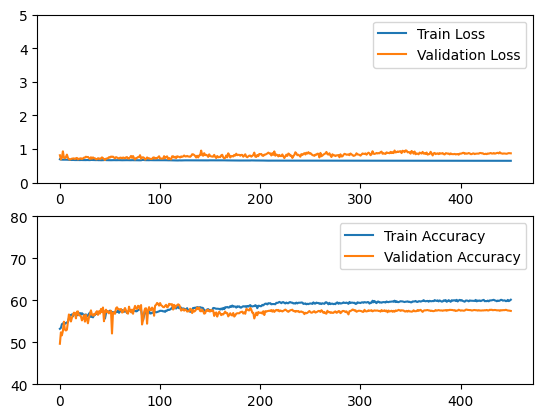

In [27]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(range(len(list_tr_loss )), list_tr_loss , label='Train Loss')
axs[0].plot(range(len(list_val_loss)), list_val_loss, label='Validation Loss')
axs[0].set_ylim([0,5])

axs[1].plot(range(len(list_tr_acc)), list_tr_acc, label='Train Accuracy')
axs[1].plot(range(len(list_val_acc)), list_val_acc, label='Validation Accuracy')
axs[1].set_ylim([40,80])

axs[0].legend()
axs[1].legend()
plt.show()